<h1 align="center">Excerpt from: "Volume 2: The Fourier Transform".</h1>

    Darian Comsa
    Math 321.001
    due 12-6-18

<h2 align="center">Part 1: The Discrete Fourier Transform</h2>

In [6]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.io import wavfile
from scipy.fftpack import fft, ifft, fft2, ifft2
from scipy import linalg as la
from scipy.signal import fftconvolve as fftc
import IPython
import imageio
from scipy import linalg as la
from scipy import sparse
from scipy.sparse import linalg as spla

In [7]:
plt.rcParams["figure.dpi"] = 300             # Fix plot quality.
plt.rcParams["figure.figsize"] = (12,3)      # Change plot size / aspect (you may adjust this).

In [8]:
class SoundWave(object):
    """A class for working with digital audio signals.
    
    Attributes:
        rate (int): the sample rate of the sound.
        samples ((n,) ndarray): NumPy array of samples.
    """

    # Problem 1.1
    def __init__(self, rate, samples):
        """Set the SoundWave class attributes.

        Parameters:
            rate (int): The sample rate of the sound.
            samples ((n,) ndarray): NumPy array of samples.
        """
        self.rate = rate
        self.samples = samples

    # Problems 1.1 and 1.7
    def plot(self, find_dft=False):
        """Plot the graph of the sound wave (time versus amplitude)."""
        # plot the sound wave
        num_s = len(self.samples)
        if num_s == 0:
            raise ValueError("There are no sample points.")
        secs = num_s / self.rate
        samptimes = np.linspace(0, secs, num_s, endpoint=False)
#         axes_lims = [0, secs, -32768, 32767]
        
        if find_dft:
            dft_abs = np.abs(fft(self.samples))[:num_s//2]
            domain = np.arange(num_s//2) / num_s * self.rate
            
            plt.subplot(121)
            plt.plot(domain, dft_abs)
            plt.title("Frequency Domain")
            plt.xlabel("Frequency (Hz)")
            plt.ylabel("Magnitude")
            plt.subplot(122)
            
        plt.plot(samptimes, self.samples)
        plt.title("Sound Wave")
        plt.xlabel("Time (seconds)")
        plt.ylabel("Amplitude of Samples")
#         plt.axis(axes_lims)
        
        plt.show()

    # Problem 1.2
    def export(self, filename, force=False):
        """Generate a wav file from the sample rate and samples. 
        If the array of samples is not of type np.int16, scale it before 
        exporting.

        Parameters:
            filename (str): The name of the wav file to export the sound to.
            force (bool): default is False. If force, will rescale the samples
        """
        # check if type is numpy.int16 or if force==True
        if type(self.samples[0]) != np.int16 or force:
            # print(type(self.samples[0]))
            scaled_samples = np.int16((
                self.samples * 32767. / np.max(abs(self.samples))).real)
        else:
            scaled_samples = self.samples.real
        # write the file
        wavfile.write(filename, self.rate, scaled_samples)
    
    # Problem 1.4
    def __add__(self, other):
        """Combine the samples from two SoundWave objects.

        Parameters:
            other (SoundWave): An object containing the samples to add
                to the samples contained in this object.
        
        Returns:
            (SoundWave): A new SoundWave instance with the combined samples.

        Raises:
            ValueError: if the two sample arrays are not the same length.
        """
        if self.rate != other.rate:
            raise ValueError("SoundWave objects have different sample rates")
        # add samples
        sw = SoundWave(self.rate, self.samples + other.samples)
        
        return sw

    # Problem 1.4
    def __rshift__(self, other):
        """Concatentate the samples from two SoundWave objects.

        Parameters:
            other (SoundWave): An object containing the samples to concatenate
                to the samples contained in this object.

        Raises:
            ValueError: if the two sample rates are not equal.
        """
        if self.rate != other.rate:
            raise ValueError("SoundWave objects have different sample rates")
        # append samples
        sw = SoundWave(self.rate, np.hstack((self.samples, other.samples)))
        
        return sw
    
    # Problem 2.1
    def __mul__(self, other):
        """Convolve the samples from two SoundWave objects using 
        circular convolution.
        
        Parameters:
            other (SoundWave): An object containing the samples to convolve
                with the samples contained in this object.
        
        Returns:
            (SoundWave): A new SoundWave instance with the convolved samples.

        Raises:
            ValueError: if the two sample rates are not equal.
        """
        if self.rate != other.rate:
            raise ValueError("SoundWave objects have different sample rates")
        self_len = len(self.samples)
        other_len = len(other.samples)
        # pad the lengths
        if self_len < other_len:
            n_self = np.hstack((self.samples, np.zeros(other_len - self_len)))
            n_other = other.samples
        else:
            n_self = self.samples
            n_other = np.hstack((other.samples, np.zeros(self_len - other_len)))
        new_samples = ifft(fft(n_self) * fft(n_other)).real
        sw = SoundWave(self.rate, new_samples)
        
        return sw

    # Problem 2.2
    def __pow__(self, other):
        """Convolve the samples from two SoundWave objects using 
        linear convolution.
        
        Parameters:
            other (SoundWave): An object containing the samples to convolve
                with the samples contained in this object.
        
        Returns:
            (SoundWave): A new SoundWave instance with the convolved samples.

        Raises:
            ValueError: if the two sample rates are not equal.
        """
        if self.rate != other.rate:
            raise ValueError("SoundWave objects have different sample rates")
        self_len = len(self.samples)
        other_len = len(other.samples)
        comb_len = self_len + other_len
        len_pwr = 1
        while len_pwr < comb_len - 1:
            len_pwr *= 2
        # adjust the length
        n_self = np.hstack((self.samples, np.zeros(len_pwr - self_len)))
        n_other = np.hstack((other.samples, np.zeros(len_pwr - other_len)))
        new_samples = ifft(fft(n_self) * fft(n_other)).real
        sw = SoundWave(self.rate, new_samples[:comb_len])
        
        return sw

    # Problem 2.4
    def clean(self, low_freq, high_freq):
        """Remove a range of frequencies from the samples using the DFT. 

        Parameters:
            low_freq (float): Lower bound of the frequency range to zero out.
            high_freq (float): Higher boound of the frequency range to zero out.
        """
        n = len(self.samples)
        klo = int(low_freq * n / self.rate)
        khi = int(high_freq * n / self.rate) + 1
        dft = fft(self.samples)
        # use fancy indexing
        cutout = np.hstack( (np.arange(klo, khi), np.arange(n-khi, n-klo)) )
        dft[cutout] = 0
        self.samples = ifft(dft).real
        
    def boost(self, low_freq, high_freq, boost=2.):
        """Boost the frequencies in the given range using the DFT.
        
        Parameters:
            low_freq (float): Lower bound of the frequency range to boost.
            high_freq (float): Higher boound of the frequency range to boost.
            boost (float): the amount to boost the range
        """
        n = len(self.samples)
        klo = int(low_freq * n / self.rate)
        khi = int(high_freq * n / self.rate) + 1
        dft = fft(self.samples)
        # boost the coefficients
        booster = np.hstack( (np.arange(klo, khi), np.arange(n-khi, n-klo)) )
        dft[booster] *= boost
        self.samples = ifft(dft).real
        
    def __sub__(self, other):
        """Adjust self by frequencies unique to other."""
        # take the dfts of each and subtract out the frequencies
        if self.rate != other.rate:
            raise ValueError("SoundWave objects have different sample rates")
        self_len = len(self.samples)
        other_len = len(other.samples)
        comb_len = self_len + other_len
        len_pwr = 1
        while len_pwr < comb_len - 1:
            len_pwr *= 2
        # pad lengths
        n_self = np.hstack((self.samples, np.zeros(len_pwr - self_len)))
        n_other = np.hstack((other.samples, np.zeros(len_pwr - other_len)))
        sdft = fft(n_self)
        diff_dft = np.abs(sdft - fft(n_other))
        new_samples = ifft(sdft * diff_dft).real
        sw = SoundWave(self.rate, new_samples[:comb_len])
        
        return sw

### Problem 1.3

- Implement `generate_note()`.
- Use `generate_note()` to create an A tone that lasts for two seconds. Embed it in the notebook.

In [9]:
def hit_sample(n):
    """Return positive of a normal distribution of points."""
    domain = np.linspace(0, 5, n)
    return 1/(np.sqrt(2*np.pi))*np.exp(-domain**2/(2))

In [10]:
# def isolate(freq, samples, sigma=1.):
#     """Bring out frequencies distributed near the input frequency.

#     Parameters:
#         freq (float): frequency to be mean of normal distribution
#         sigma (float): standard deviation of boosted frequencies
#     """
#     rate = 44100
#     n = len(samples)
#     sigma *= n/4400*np.sqrt(freq)
#     kmean = int(freq * n / rate)
#     n_odd = (n % 2 != 0)
#     domain = 0
#     if n_odd:
#         domain = np.arange(0, n//2 + 1)
#     else:
#         domain = np.arange(0, n//2)
#     normal = 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(domain-kmean)**2/(2*sigma**2))
#     norm_sym = 0
#     if n_odd:
#         norm_sym = np.hstack((normal, normal[:0:-1]))
#     else:
#         norm_sym = np.hstack((normal, normal[::-1]))
#     dft = fft(samples) * norm_sym
#     return ifft(dft).real

In [11]:
# phase is not implemented yet (smooths sine waves...)
def generate_note(frequency, duration, instrument='sine', phase=0, other=None):
    """Generate an instance of the SoundWave class corresponding to 
    the desired soundwave. Uses sample rate of 44100 Hz.
    
    Parameters:
        frequency (float): The frequency of the desired sound.
        duration (float): The length of the desired sound in seconds.
    
    Returns:
        sound (SoundWave): An instance of the SoundWave class.
    """
    # new_phase = frequency 
    rate = 44100
    num_s = int(rate * duration)
    domain = np.linspace(0, duration, num_s, endpoint=False)
    pwr = 1
    if instrument[:5] in ('sinep',):
        params = instrument.split('_')
        pwr = int(params[1])
#         if pwr % 2 == 0:
#             frequency /= 2
        instrument = params[0]
    if instrument == 'voice':
        pwr = other
    instruments = {'sine':sine_wave, 'square':square_wave, 
                   'sinep':sinepwr_wave, 'sawtooth':sawtooth_wave,
                   'triangle':triangle_wave, 'snare_hit':snare_hit,
                   'cymbal':cymbal, 'voice':voice
                  }
    voice_function = instruments[instrument]
    
    if frequency != 0:
        samples = voice_function(frequency, domain, pwr)
    else:
        samples = frequency * domain
    if 20 < frequency < 220 and instrument=='sine':
        bass_boost = 6*220 / frequency
        samples *= bass_boost
    sw = SoundWave(rate, samples)
    
    return sw

def sine_wave(frequency, samples, pwr=1):
    """Returns sinusoidal samples unchanged."""
    return np.sin(2*np.pi * frequency * samples)

def square_wave(frequency, samples, pwr=1):
    """Take the sign of the samples and return the square wave."""
    # 0,1,0,-1,0
    return np.sign(sine_wave(frequency, samples))

def sinepwr_wave(frequency, samples, pwr=2):
    """Exponent the samples."""
    samples = sine_wave(frequency, samples)
    if pwr % 2 != 0:
        samples = samples ** pwr
    else:
        samples = (samples + 1) / 2
        samples = samples ** pwr
        samples = 2 * samples - 1
    return samples

def sawtooth_wave(frequency, samples, pwr=1):
    """Turn into sawtooth."""
    samples = samples % (1/frequency)
    mean = max(samples)/2
    return samples - mean

def triangle_wave(frequency, samples, pwr=1):
    """Turn samples into triangle."""
    samples = 2 * np.abs(sawtooth_wave(frequency, samples))
    mean = max(samples)/2
    return samples - mean

def snare_hit(frequency, samples, sigma=1.):
    """Make white noise percussion."""
    n = len(samples)
    hits = np.random.rand(n)
    return hits

def cymbal(frequency, samples, pwr=1):
    """Make white noise percussion."""
    n = len(samples)
    hits = hit_sample(n)
    hits *= np.random.rand(n)
    return 10*hits

def voice(frequency, samples, other):
    """Make a voice sample with info in other."""
    pass

class Compose(object):
    """A class to generate music from instances of the SoundWave class using 
    the notes input.
    
    Attributes:
        tempo (float): how many beats per minute
        tracks (list): list of lists, each starting with the instrument,
                with tuples of notes of the form note=("tone",...,"tone", beats)
        soundwave (SoundWave): the rate and samples stored in a SoundWave object
        
    Example:
        tempo = 144
        tracks = [
                ['sine', ('a4',1), ('c#5',1), ('e5',2), ('a4','c#5','e5',4) ],
                ['sine_3', ('f#3',1),('g#3',1),('a3',2),('a3',4)]
                ]
    Notice:
        Tones include [a,b,c,d,e,f,g]; # is accepted before the octave number.
        The number following is the octave number.
        'c4' is middle C, a4 is the next A above c4 (A440).
        If the tracks are not of the same size, they will be padded at the end.
    """

    def __init__(self, tempo, tracks):
        """Generate an instance of the SoundWave class that uses the notes input.
        """
        hs = 2**(1 / 12) # half step is 12 root of 2 up or down
        # beats per second is tempo / 60
        bps = tempo / 60.
        scale = {'c':0, 'd':2, 'e':4, 'f':5, 'g':7, 'a':9, 'b':11}

        music = generate_note(0,0)
        for notes in tracks:
            instrument = notes[0]
            track = generate_note(0,0)
            for note in notes[1:]:
                tones = note[:-1]
                beats = note[-1]
                # parse each tone
                sw = generate_note(0, beats / bps, instrument)
                if len(tones) != 0:
                    for tone in tones:
                        n = scale[tone[0]]
                        if tone[1] == '#':
                            n += 1
                            n += 12*(float(tone[2]) - 4)
                        else:
                            n += 12*(float(tone[1]) - 4)
                        n -= 9
                        sw += generate_note(440 * hs**n, beats / bps, instrument)
                track = track >> sw
            mml = len(music.samples)
            ttl = len(track.samples)
            if mml < ttl:
                # pad music
                music.samples = np.hstack((music.samples, np.zeros(ttl - mml) ))
            else:
                # make track longer
                track.samples = np.hstack((track.samples, np.zeros(mml - ttl) ))
            music = music + track

        self.soundwave = music

    # TODO: instead of starting the sine wave over again each time, keep track of 
    #         where the phase is and start the next sine wave there...
    #         but how do I differentiate a note that is held and a repeated note?
    #         should I put a character before or after the note name?
    #         I think putting a tied note character before might help;
    #         it will generalize to note articulation...

In [12]:
# whn = generate_note(440,.06,'snare_hit')
# whn.export("white_noise1.wav", True)
# IPython.display.Audio("white_noise1.wav")

In [13]:
# whn = generate_note(1760,.125,'snare_hit')
# whn.export("snare_ex.wav", True)
# IPython.display.Audio("snare_ex.wav")

In [14]:
sw = generate_note(440, 2)
sw.export("A440.wav", True)
# rate, samples = wavfile.read('A440.wav')
# sw = SoundWave(rate, samples[:440])
# sw.plot()

In [15]:
# IPython.display.Audio("A440.wav")

In [16]:
sq = generate_note(440, 2, 'square')
sq.export("A4_square.wav", True)
# rate, samples = wavfile.read('A4_square.wav')
# sq = SoundWave(rate, samples[:440])
# sq.plot()

# IPython.display.Audio("A4_square.wav")

In [17]:
sq2 = generate_note(440, 2, 'sinep_16')
sq2.export("A4_sine_pwr.wav", True)
# rate, samples = wavfile.read('A4_sine_pwr.wav')
# sq2 = SoundWave(rate, samples[:440])
# sq2.plot()

# IPython.display.Audio("A4_sine_pwr.wav")

In [18]:
sq2 = generate_note(440, 2, 'sinep_7')
sq2.export("A4_sine_pwr2.wav", True)
# rate, samples = wavfile.read('A4_sine_pwr2.wav')
# sq2 = SoundWave(rate, samples[:440])
# sq2.plot()

# IPython.display.Audio("A4_sine_pwr2.wav")

In [19]:
sa = generate_note(440, 2, 'sawtooth')
sa.export("A4_sawtooth.wav", True)
# rate, samples = wavfile.read('A4_sawtooth.wav')
# sa = SoundWave(rate, samples[:440])
# sa.plot()

# IPython.display.Audio("A4_sawtooth.wav")

In [20]:
st = generate_note(440, 2, 'triangle')
st.export("A4_triangle.wav", True)
# rate, samples = wavfile.read('A4_triangle.wav')
# st = SoundWave(rate, samples[:440])
# st.plot()

# IPython.display.Audio("A4_triangle.wav")

In [21]:
sn = generate_note(880, 1, 'cymbal')
sn.export("snare_ex.wav", True)
# rate, samples = wavfile.read('A4_triangle.wav')
# st = SoundWave(rate, samples[:440])
# st.plot()

# IPython.display.Audio("snare_ex.wav")

### Problem 1.4

- Implement `SoundWave.__add__()`.
- Generate a three-second A minor chord (A, C, and E) and embed it in the notebook.
- Implement `SoundWave.__rshift__()`.
- Generate the arpeggio A$\,\rightarrow\,$C$\,\rightarrow\,$E, where each tone lasts one second, and embed it in the notebook.

In [22]:
half_step = 2**(1 / 12)

In [23]:
A4 = generate_note(440, 3)
C5_exact = generate_note(440 * half_step**3, 3)
E5_exact = generate_note(440 * half_step**7, 3)
Ami_exact = A4 + C5_exact + E5_exact
Ami_exact.export("Aminor_exact.wav", True)

In [24]:
# IPython.display.Audio("Aminor_exact.wav")

In [25]:
A4 = generate_note(440, 1)
C4_exact = generate_note(440 * half_step**3, 1)
E4_exact = generate_note(440 * half_step**7, 1)
Ami_arpeggio = A4 >> C4_exact >> E4_exact
Ami_arpeggio.export("Aminor_arpeggio.wav", True)

In [26]:
# IPython.display.Audio("Aminor_arpeggio.wav")

In [27]:
tempo = 144
tracks = [
            ['sinep_4', ('c#5',1), ('d5',1), ('e5',2), ('c#5','e5','a5',4) ],
            ['cymbal', ('e4',1),('a4',1),('c#5',2),('c#5',4)]
        ]
song = Compose(tempo, tracks)
song.soundwave.export("song.wav", True)
# IPython.display.Audio("song.wav")

In [28]:
tempo = 96
notes = [
    ['sinep_18',
    ('a#2','a#3','a#4','d5','f5','a#5',5/3),('a#3','a#4',1/6),('a#3','a#4',1/6),
    ('a#3','a#4',1),
    ('a#3','a#4',1/3),('a#3','a#4',1/3),('a#3','a#4',1/3),
    ('a#3','a#4',1/3),('f3',1/3),('d#4','a#4',1/3),
    ('f4','a#4',1/3),('d#4','f4',1/3),('a#3','d#5',1/3),
    ('a#3','f5',1/3),('f3','d#5',1/3),('d#4','a#4',1/3),
    ('g#3','a#3','f4','a#4',1/3),('g#3','a#3','d#4','f4',1/3),('g#3','a#3','d#5',1/3),
    ('d#3','f4','a#4','f5',1/3),('a#2','d#5',1/3),('f3','a#4',1/3),
    ('g#3','a#3','d#4','a#4',1/3),('g#3','a#3','f4',1/3),('g#3','a#3','d#5',1/3),
    ('g#3','a#3','f5',1/3),('g#3','a#3','a#4',11/60),('g#3','a#3','a#4',1/5),('g#3','a#3','a#4',2/5),
    ('f2','f4',2/5),('f2','f4',1/2),('f2','f4',11/20),
    ('a#4',3/4),('a#2','a#3','d4','f4','a#4',1/4),
    ('a#2','a#3','d4','f4','a#4',1),
    ('f5',1/2),('a#2','a#3','f4','a#4','d5','f5',1/4),('a#2','a#3','f4','a#4','d5','f5',1/4),
    ('a#2','a#3','f4','a#4','d5','f5',1/2),('f2','g#4','a#4','d#5','f5',1/2),
    ('d#5',1/3),('d5',1/3),('c5',1/3),
    ('a#5',1/2),('f2','g#4','a#4','d#5','a#5',1/2),
    ('f2','g#4','a#4','d#5','a#5',1/3),('f2','g#4','a#4','d#5','a#5',1/3),('f2','g#4','a#4','d#5','a#5',1/3),
    ('a#2','a#4','d5','f5',1/3),('a#2','a#4','d5','f5',1/3),('a#2','a#4','d5','f5',1/3),
    ('d#5',1/3),('d5',1/3),('c5',1/3),
    ('a#5',1/2),('f2','g#4','a#4','d#5','a#5',1/2),
    ('f2','g#4','a#4','d#5','a#5',1/3),('f2','g#4','a#4','d#5','a#5',1/3),('f2','g#4','a#4','d#5','a#5',1/3),
    ('a#2','a#4','d5','f5',1/3),('a#2','a#4','d5','f5',1/3),('a#2','a#4','d5','f5',1/3),
    ('g#2','c5','d#5',1/3),('g2','b4','d5',1/3),('g#2','c5','d#5',1/3),
    ('f2','a4','c5',1),
    ('f2','f3','a4','c5',1/3),('f2','f3','a4','c5',1/3),('f2','f3','a4','c5',1/3),
    ('f2','f3','f4',1/3),('f2','f3','f4',1/3),('f2','f3','f4',1/3),
    ('a#2','d4','f4','a#4',1),
    ('a2','d4','f4','a#4',1),
    ('a2','d4','f4','f5',2/3),('a2','d4','f4','a#4','d5','f5',1/3),
    ('a#2','d4','f4','a#4','d5','f5',1/3),('a#2','d4','f4','a#4','d5','f5',1/3),('a2','d4','f4','a#4','d5','f5',1/3),
    ('g2','d#4','g4','a#4','d#5',1/3),('g2','d#4','g4','a#4','d5',1/3),('g2','d#4','g4','a#4','c5',1/3),
    ('g2','f4','a#4','d#5','a#5',2/3),('d#3','g4','a#4','d#5','a#5',1/3),
    ('d#3','g4','a#4','d#5','a#5',1/3),('d3','g4','a#4','d#5','a#5',1/3),('c3','g4','a#4','d#5','a#5',1/3),
    ('a#2','f4','a#4','d5','f5',1/3),('a2','f4','a#4','d5','f5',1/3),('g2','f4','a#4','d5','f5',1/3),
    ('f2','d#4','g4','a#4','d#5',1/3),('f2','d#4','g4','a#4','d5',1/3),('f2','d#4','g4','a#4','c5',1/3),
    ('g2','d#4','d#5','g5','a#5',1/2),('a2','d#4','d#5','g5','a#5',1/2),
    ('a#2','d4','a#4','d5','a#5',1/3),('a2','d4','a#4','d5','a#5',1/3),('g2','d4','a#4','d5','a#5',1/3),
    ('f2','f4','a#4','d5','f5',1/2),('a#2','f4','a#4','d5','f5',1/2),
    ('f1','f2','g#4','c5','d#5',1/3),('f1','f2','g#4','b4','d5',1/3),('f1','f2','g#4','c5','d#5',1/3),
    ('f1','f2','f4','a4','c5',3)
    ]
]
star_wars = Compose(tempo, notes)
star_wars.soundwave.export("star_wars.wav",True)

# IPython.display.Audio("star_wars.wav")

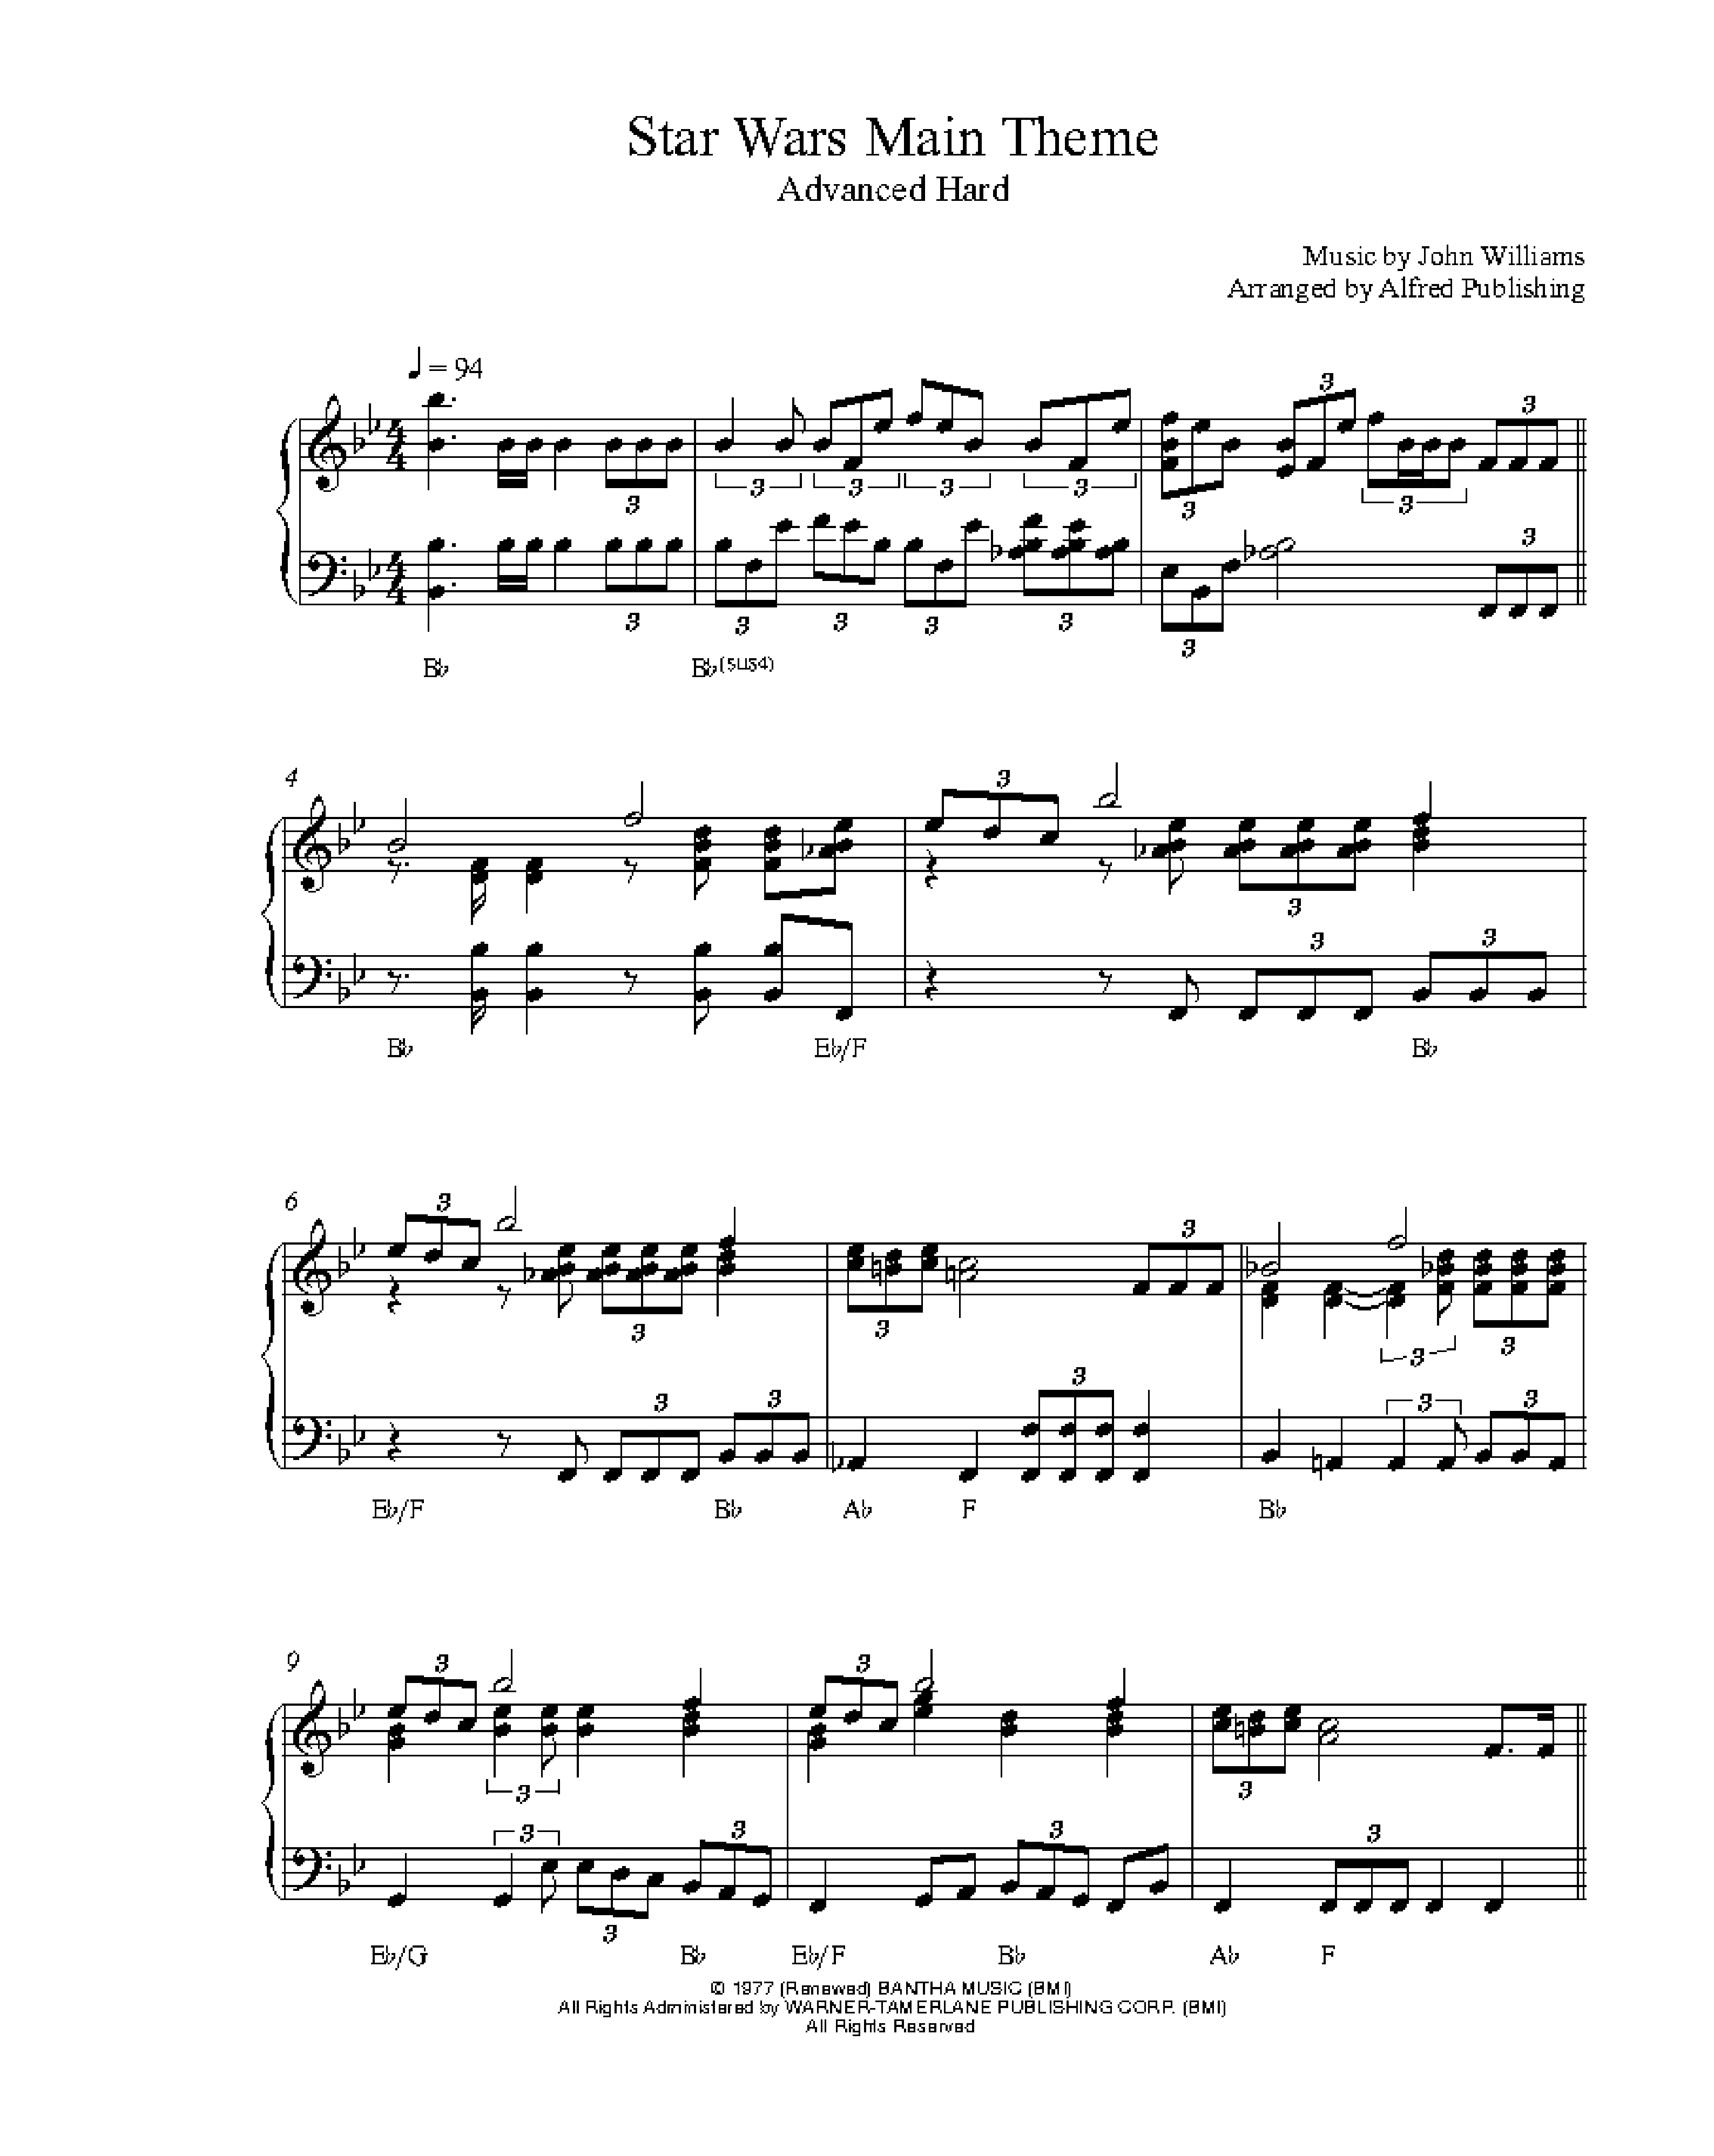

In [29]:
# https://www.playgroundsessions.com/store/view-song/star-wars-main-theme-piano-sheet-music-advanced
sheet_music = imageio.imread("star_wars_sheet_music.png")
# print(len(sheet_music))
plt.figure(figsize=(22,17))
plt.imshow(sheet_music)
plt.axis('off')
plt.show()

In [30]:
tempo = 100
notes = [
    ['square',
    ('d3','f#4','e5',1/4),('d3','f#4','e5',1/4),(1/4,),('d3','f#4','e5',1/4),
    (1/4,),('d3','f#4','c5',1/4),('d3','f#4','e5',1/16),('d3','f#4','e5','a4',3/16),('a#4',1/16),('b4',1/16),('c5',1/16),('c#5',1/16),
    ('g3','g4','g4','b4','d5','g5',1/16),('g3','g4','b4','b4','d#5','g5',1/16),('g3','g4','b4','d5','g5',1/16),('g3','g4','b4','g5','g5',1/16),('d5',1/16),('g#4',1/16),('c5',1/16),('d#5',1/16),('g#5',1/16),('d#5',1/16),('g#5',1/16),('c6',1/16),('d#6',1/16),('g#6',1/16),('d#6',1/16),('a#4',1/16),
    ('g2','g4','d5',1/16),('g2','g4','f5',1/16),('g2','g4','a#5',1/16),('g2','g4','f5',1/16),('a#5',1/16),('d6',1/16),('f6',1/16),('a#6',1/16),(1/2,),
    ('g3','e4','c5',1/4),(1/2,),('e3','c4','g4',1/4),(1/2,),('c3','g3','e4',1/4),
    (1/2,),('f3','c4','a4',1/4),(1/4,),('g3','d4','b4',1/4),(1/4,),('f#3','c#4','a#4',1/4),('f3','c4','a4',1/4),(1/4,),
    ('e3','c4','g4',1/4),(1/12,),('c4','g4','e5',1/4),(1/12,),('e4','b4','g5',1/4),(1/12,),('f4','c5','a5',1/4),(1/4,),('d4','a4','f5',1/4),('e4','b4','g5',1/4),(1/4,),
    ('c4','a4','e5',1/4),(1/4,),('a3','e4','c5',1/4),('b3','f4','d5',1/4),('g3','d4','b4',1/4),(1/2,),
    ('g3','e4','c5',1/4),(1/2,),('e3','c4','g4',1/4),(1/2,),('c3','g3','e4',1/4),(1/4,),
    (1/4,),('f3','c4','a4',1/4),(1/4,),('g3','d4','b4',1/4),(1/4,),('f#3','c#4','a#4',1/4),('f3','c4','a4',1/4),(1/4,),
    ('e3','c4','g4',1/4),(1/12,),('c4','g4','e5',1/4),(1/12,),('e4','b4','g5',1/4),(1/12,),('f4','c5','a5',1/4),(1/4,),('d4','a4','f5',1/4),('e4','b4','g5',1/4),(1/4,),
    ('c4','a4','e5',1/4),(1/4,),('a3','e4','c5',1/4),('b3','f4','d5',1/4),('g3','d4','b4',1/4),(1/2,),
    ('c3',1/4),(1/4,),('e5','g5',1/4),('g3','d#5','f#5',1/4),('d5','f5',1/4),('b4','d#5',1/4),('c4',1/4),('c5','e5',1/4),
    ('f3',1/4),('e4','g#4',1/4),('f4','a4',1/4),('c4','g4','c5',1/4),('c4',1/4),('c4','a4',1/4),('f3','e4','c5',1/4),('f4','d5',1/4),
    ('c3',1/4),(1/4,),('e5','g5',1/4),('e3','d#5','f#5',1/4),('d5','f5',1/4),('b4','d#5',1/4),('g3','b4','d#5',1/4),('c4','c5','e5',1/4),
    (1/4,),('f5','g5','c6',1/4),(1/4,),('f5','g5','c6',1/4),('f5','g5','c6',1/4),(1/4,),('g3',1/4),(1/4,),
    ('c3',1/4),(1/4,),('e5','g5',1/4),('g3','d#5','f#5',1/4),('d5','f5',1/4),('b4','d#5',1/4),('c4',1/4),('c5','e5',1/4),
    ('f3',1/4),('e4','g#4',1/4),('f4','a4',1/4),('c4','g4','c5',1/4),('c4',1/4),('c4','a4',1/4),('f3','e4','c5',1/4),('f4','d5',1/4),
    ('c3',1/4),(1/4,),('g#3','g#4','d#5',1/4),(1/2,),('a#3','f4','d5',1/4),(1/2,),
    ('c4','e4','c5',1/4),(1/2,),('g3',1/4),('g3',1/4),(1/4,),('c3',1/4),(1/4,),
    ('c3',1/4),(1/4,),('e5','g5',1/4),('g3','d#5','f#5',1/4),('d5','f5',1/4),('b4','d#5',1/4),('c4',1/4),('c5','e5',1/4),
    ('f3',1/4),('e4','g#4',1/4),('f4','a4',1/4),('c4','g4','c5',1/4),('c4',1/4),('c4','a4',1/4),('f3','e4','c5',1/4),('f4','d5',1/4),
    ('c3',1/4),(1/4,),('e5','g5',1/4),('e3','d#5','f#5',1/4),('d5','f5',1/4),('b4','d#5',1/4),('g3','b4','d#5',1/4),('c4','c5','e5',1/4),
    (1/4,),('f5','g5','c6',1/4),(1/4,),('f5','g5','c6',1/4),('f5','g5','c6',1/4),(1/4,),('g3',1/4),(1/4,),
    ('c3',1/4),(1/4,),('e5','g5',1/4),('g3','d#5','f#5',1/4),('d5','f5',1/4),('b4','d#5',1/4),('c4',1/4),('c5','e5',1/4),
    ('f3',1/4),('e4','g#4',1/4),('f4','a4',1/4),('c4','g4','c5',1/4),('c4',1/4),('c4','a4',1/4),('f3','e4','c5',1/4),('f4','d5',1/4),
    ('c3',1/4),(1/4,),('g#3','g#4','d#5',1/4),(1/2,),('a#3','f4','d5',1/4),(1/2,),
    ('c4','e4','c5',1/4),(1/2,),('g3',1/4),('g3',1/4),(1/4,),('c3',1/4),(1/4,),
    ]
    ,
    ['cymbal',
     ('a6',1/4),(1/4,),('a6',1/8),(1/8,),('a6',1/8),(1/8,),
     (1/4,),('a6',1/8),(1/8,),('a6',1/4),(1/4,),
     ('a6',1/4),(4/8,),('a6',1/4),
     (1/4,),('a6',1/8),(1/8,),('a6',1/8),(1/8,),('a6',1/8),(1/8,),
     ('a4',1/8),(3/8,),('a6',3/24),(5/24,),('a6',3/24),(1/24,),('a5',1/4),(1/4,),('a6',3/24),(5/24,),('a6',3/24),(1/24,),
     ('a4',1/8),(3/8,),('a6',3/24),(5/24,),('a6',3/24),(1/24,),('a5',1/4),(1/4,),('a6',3/24),(5/24,),('a6',3/24),(1/24,),
     ('a4',1/8),(3/8,),('a6',3/24),(5/24,),('a6',3/24),(1/24,),('a5',1/4),(1/4,),('a6',3/24),(5/24,),('a6',3/24),(1/24,),
     ('a4',1/8),(3/8,),('a6',3/24),(5/24,),('a6',3/24),(1/24,),('a5',1/4),(1/4,),('a6',3/24),(5/24,),('a6',3/24),(1/24,),
     ('a4',1/8),(3/8,),('a6',3/24),(5/24,),('a6',3/24),(1/24,),('a5',1/4),(1/4,),('a6',3/24),(5/24,),('a6',3/24),(1/24,),
     ('a4',1/8),(3/8,),('a6',3/24),(5/24,),('a6',3/24),(1/24,),('a5',1/4),(1/4,),('a6',3/24),(5/24,),('a6',3/24),(1/24,),
     ('a4',1/8),(3/8,),('a6',3/24),(5/24,),('a6',3/24),(1/24,),('a5',1/4),(1/4,),('a6',3/24),(5/24,),('a6',3/24),(1/24,),
     ('a4',1/8),(3/8,),('a6',3/24),(5/24,),('a6',3/24),(1/24,),('a5',1/4),(1/4,),('a6',3/24),(5/24,),('a6',3/24),(1/24,),
     ('a4',1/8),(3/8,),('a6',3/24),(5/24,),('a6',3/24),(1/24,),('a5',1/4),(1/4,),('a6',3/24),(5/24,),('a6',3/24),(1/24,),
     ('a4',1/8),(3/8,),('a6',3/24),(5/24,),('a6',3/24),(1/24,),('a5',1/4),(1/4,),('a6',3/24),(5/24,),('a6',3/24),(1/24,),
     ('a4',1/8),(3/8,),('a6',3/24),(5/24,),('a6',3/24),(1/24,),('a5',1/4),(1/4,),('a6',3/24),(5/24,),('a6',3/24),(1/24,),
     ('a4',1/8),(3/8,),('a6',3/24),(5/24,),('a6',3/24),(1/24,),('a5',1/4),(1/4,),('a6',3/24),(5/24,),('a6',3/24),(1/24,),
     ('a4',1/8),(3/8,),('a6',3/24),(5/24,),('a6',3/24),(1/24,),('a5',1/4),(1/4,),('a6',3/24),(5/24,),('a6',3/24),(1/24,),
     ('a4',1/8),(3/8,),('a6',3/24),(5/24,),('a6',3/24),(1/24,),('a5',1/4),(1/4,),('a6',3/24),(5/24,),('a6',3/24),(1/24,),
     ('a4',1/8),(3/8,),('a6',3/24),(5/24,),('a6',3/24),(1/24,),('a5',1/4),(1/4,),('a6',3/24),(5/24,),('a6',3/24),(1/24,),
     ('a4',1/8),(3/8,),('a6',3/24),(5/24,),('a6',3/24),(1/24,),('a5',1/4),(1/4,),('a6',3/24),(5/24,),('a6',3/24),(1/24,),
     ('a4',1/8),(3/8,),('a6',3/24),(5/24,),('a6',3/24),(1/24,),('a5',1/4),(1/4,),('a6',3/24),(5/24,),('a6',3/24),(1/24,),
     ('a4',1/8),(3/8,),('a6',3/24),(5/24,),('a6',3/24),(1/24,),('a5',1/4),(1/4,),('a6',3/24),(5/24,),('a6',3/24),(1/24,),
     ('a4',1/8),(3/8,),('a6',3/24),(5/24,),('a6',3/24),(1/24,),('a5',1/4),(1/4,),('a6',3/24),(5/24,),('a6',3/24),(1/24,),
     ('a4',1/8),(3/8,),('a6',3/24),(5/24,),('a6',3/24),(1/24,),('a5',1/4),(1/4,),('a6',3/24),(5/24,),('a6',3/24),(1/24,),
     ('a4',1/8),(3/8,),('a6',3/24),(5/24,),('a6',3/24),(1/24,),('a5',1/4),(1/4,),('a6',3/24),(5/24,),('a6',3/24),(1/24,),
     ('a4',1/8),(3/8,),('a6',3/24),(5/24,),('a6',3/24),(1/24,),('a5',1/4),(1/4,),('a6',3/24),(5/24,),('a6',3/24),(1/24,),
     ('a4',1/8),(3/8,),('a6',3/24),(5/24,),('a6',3/24),(1/24,),('a5',1/4),(1/4,),('a6',3/24),(5/24,),('a6',3/24),(1/24,),
    ]
]
mario = Compose(tempo, notes)
mario.soundwave.export("mario.wav", True)

# IPython.display.Audio("mario.wav")

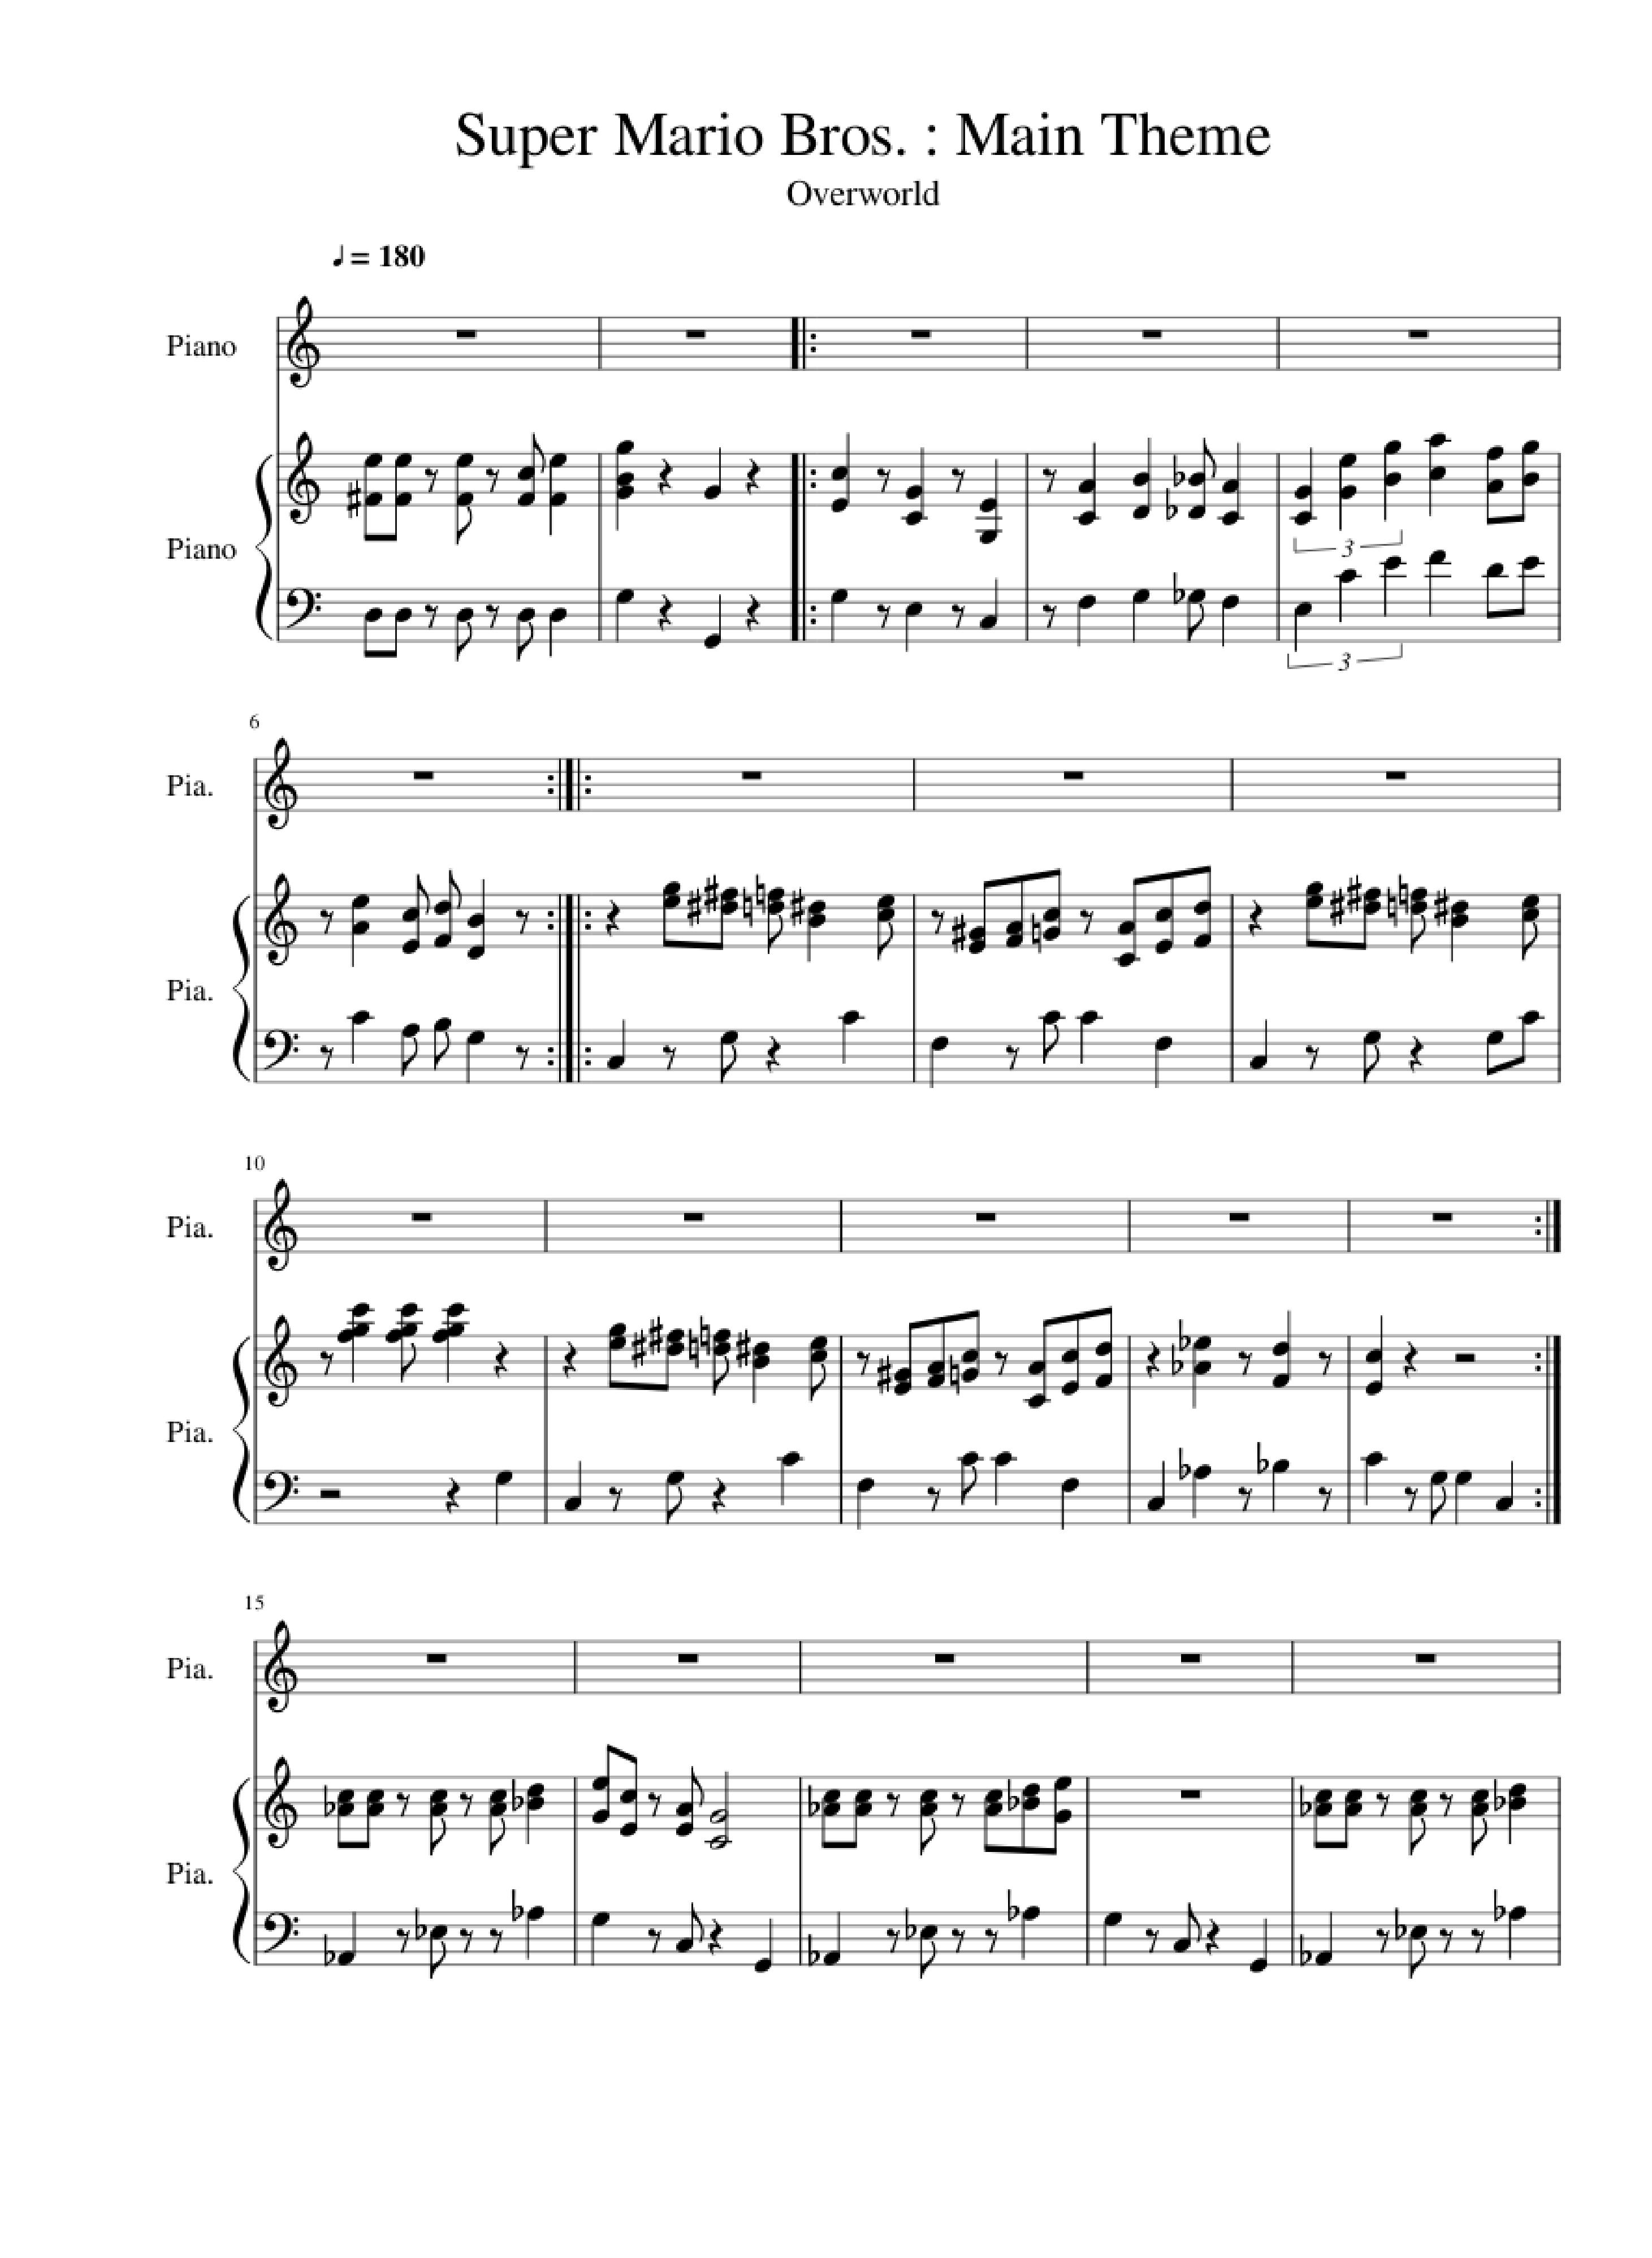

In [31]:
# https://musescore.com/neoguizmo/scores/2601926
sheet_music = imageio.imread("mario_music.png")
# print(len(sheet_music))
plt.figure(figsize=(22,17))
plt.imshow(sheet_music)
plt.axis('off')
plt.show()